### GOAL

Distinguish between overlapping circles.

### TODO

- simulate fragments overlapping combination
- test lasso regression model together with other regressions
- integrate this in the reconstruction algorithm
- test lasso regression in the pipeline using special cases
- decide on filtering criteria (e.g. remove circles with weigths <= 4X )
- decide if performing the regression on entire graph or split it on smaller components (e.g. perform regression only for ambigous sites)


In [1]:
%load_ext autoreload
%autoreload 2

## 1. Simulate ecDNA fragments (including overlaps) and test different models
Aim is to simulate randomly in silico overlapping ecDNA.<br/>
Here we focus only on the fragments overlap and not on the topology of the ecDNA.<br/>
- we test samples including 2 to 10 circles 
- with randomly generating ecDNA with (2,3,...,10) fragments 
- with defined numbers of overlapping fragments (0 to n)

For the simulation of fragment length we pool from a normal distribution mu, sigma = 70000, 30000.<br/>
For the simulation of the coverage we pool from a normal distribution covmu, covsigma = 200, 150.<br/>

The regression models included are: Ridge, Linear, Lasso and SGD Regressions.
Repeat simulation 100 times.

In [2]:
!python -m pip install scikit-learn==1.0.2

In [3]:
import numpy as np
import pandas as pd
import random
from copy import deepcopy

np.random.seed(12)

def add_subcircles(circles, coverage):
    """
    Find for the simulation all the subcircles.
    """
    subcircles = []
    for c in circles:
        for i, f in enumerate(c):
            for j in range(i+1, len(c)):
                if f == c[j]:
                    subcircles.append(tuple(c[i:j]))
    
    # remove duplicates
    no_dups = list(set(subcircles))
    original_circles = deepcopy(circles)
    
    for tup in no_dups:
        if tup not in original_circles:
            # add all subcircles
            circles.append(tup)

            # set coverage on 0 (because this is not a true circle)
            coverage.append(0)


def simulate_overlapping_circles(nr_circles, nr_fragments, nr_overlapping_frags, interval=100, fixsize=True):
    circles = []
    
    if fixsize == True:
        n_frag = [nr_fragments] * nr_circles
    else:
        # variable size of the circles
        n_frag = list(np.random.choice(range(2, nr_fragments), nr_circles, replace=True))
#         print("Variable nr of fragments", n_frag)
        nr_overlapping_frags = min(n_frag) - 1
#         print("Overlapping fragments", nr_overlapping_frags)
    

    mu, sigma = 70000, 30000  # mean and standard deviation
    s = np.random.normal(mu, sigma, interval)

    covmu, covsigma = 200, 150  # mean and standard deviation
    coverage = list(np.random.normal(covmu, covsigma, nr_circles))

    for i in range(0,nr_circles):
        if i != 0:
            
            circle1 = []
            overlapwith = random.randint(0, len(circles)-1)
#             print("overlap with", overlapwith, circles[overlapwith], )

            # pick n fragments overlapping with
            n =  len(circles[overlapwith])
            pick_fragments = list(np.random.choice(range(0,n), nr_overlapping_frags, replace=True))
#             print(pick_fragments)
            for j in pick_fragments:
                circle1.append(circles[overlapwith][j])

            if n_frag[i]-nr_overlapping_frags > 0:
                circle1 += list(np.random.choice(range(0, interval), n_frag[i]-nr_overlapping_frags, replace=False))
            
        else:
            
            circle1 = list(np.random.choice(range(0, interval), n_frag[i], replace=True))
            
        circles.append(tuple(circle1))
#         print(circles)
    
    
    # compute all subcircles
    circles_with_subcircles = deepcopy(circles)
    coverage_with_subcircles = deepcopy(coverage)
    add_subcircles(circles_with_subcircles, coverage_with_subcircles)
    
    return circles, coverage, circles_with_subcircles, coverage_with_subcircles

In [4]:
def circles_to_matrix(circles, coverage):
    
    # find all fragments by chaining all circles (dont use flatten because we have circles of different size)
    selected_fragments = []
    for c in circles:
        selected_fragments += c
    selected_fragments = np.array(list(set(selected_fragments)))

    coverage = np.array(coverage)
    df = pd.DataFrame(0, index=selected_fragments, columns=range(0,len(circles)))

    for i in range(0, len(circles)):
        for j in range(0, len(circles[i])):
            df.loc[circles[i][j],i] += 1

    return df

def compute_cov_per_fragment(df, coverage):
    p = np.array(df) * coverage
    cov_per_fragment = np.sum(p, axis=1)
    return cov_per_fragment

In [5]:
from sklearn.linear_model import Ridge, Lasso, LassoCV, SGDRegressor, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

from numpy import dot
from numpy.linalg import norm

import scipy
import numpy as np

import warnings
warnings.filterwarnings("ignore")

def cosvectors(a,b):
    return dot(a, b)/(norm(a)*norm(b))

def compute_similarity(a,b):
    prod = a * b
    return cosvectors(prod, a), cosvectors(prod, b)
    
def print_similarity(df):
    
    M = np.array(df)
    
    if M.shape[1] > 2:
        for i in range(0, M.shape[1]-1):
            for j in range(i+1, M.shape[1]):
                print(i, j, compute_similarity(M[:,i], M[:,j]))
    else:
        print(0, 1, compute_similarity(M[:,0], M[:,1]))

def error(u, v):
    """
    Compute error between 2 vectors.
    Assume u - predicted, v - true
    """
    diff = np.subtract(u, v)
    return scipy.linalg.norm(diff)/scipy.linalg.norm(v)

def mse(u, v):
    """
    Compute mean square error between 2 vectors
    Assume u - predicted, v - true
    """
    return mean_squared_error(v, u) # true, predicted

def abs_total_error(u, v):
    """
    Compute absolute max error 
    Assume u - predicted, v - true
    """
    return np.sum(np.abs(np.subtract(u,v)))

def regress(df, y, proportions, pseudocount = 0.1, scaled=False):
    """
    df - Matrix fragments x circles
    y - total coverage per fragment
    proportions - true circle composition 
    pseudocount - remove 0 values in the matrix
    """

    M = np.array(df) + pseudocount
    if scaled == True:
        scaler = StandardScaler()
        scaler.fit(M)
        Mscaled = scaler.transform(M)
    else:
        Mscaled = M
    
    lasso = Lasso(alpha=0.1).fit(Mscaled, y)
#     lassocv = LassoCV(cv=3, random_state=0).fit(Mscaled, y)
    ridge = Ridge().fit(Mscaled, y)
    linear = LinearRegression().fit(Mscaled, y)
    sgd = SGDRegressor(max_iter=1000, tol=1e-3, average=True).fit(Mscaled, y, coef_init=[100]*Mscaled.shape[1])
    

#     print("True coefficients:", proportions)
# #     print("Lasso cross validation coefficients:", lassocv.coef_)
#     print("Lasso coefficients:", lasso.coef_)
#     print("Ridge coefficients:", ridge.coef_)
#     print("Simple coefficients:", linear.coef_)
#     print("SGD coefficients:", sgd.coef_)

# #     print(error(lassocv.coef_, proportions))
#     print(error(lasso.coef_, proportions))
#     print(error(ridge.coef_, proportions))
#     print(error(linear.coef_, proportions))
#     print(error(sgd.coef_, proportions))
#     print()
    
    
    
#     return (error(lasso.coef_, proportions),
#             error(ridge.coef_, proportions),
#             error(linear.coef_, proportions),
#             error(sgd.coef_, proportions))

    return (abs_total_error(lasso.coef_, proportions),
            abs_total_error(ridge.coef_, proportions),
            abs_total_error(linear.coef_, proportions),
            abs_total_error(sgd.coef_, proportions)),(lasso.coef_, ridge.coef_, linear.coef_, sgd.coef_)

In [6]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [7]:
import pandas as pd


def run_simulation(max_circles, max_fragments, keep_intermediate_steps = False):

    df_metrics = pd.DataFrame(columns=["Error", "Method", "Nr_Circles", "Nr_Fragments", "Nr_Overlapping_Frags", "Sim"], dtype=object)
    sim_dict = {}
    
    df_metrics1 = pd.DataFrame(columns=["Error", "Method", "Nr_Circles", "Nr_Fragments", "Nr_Overlapping_Frags", "Sim"], dtype=object)
    sim_dict1 = {}
    
    count = 0

    for ncirc in range(2, max_circles):
        nr_circles = ncirc

        print("Circles", ncirc)

        for frags in range(1, max_fragments):
            nr_fragments = frags

            for olp in range(0, frags):
                nr_overlapping_frags = olp

                for k in range(0, 10):

    #                 print("Circles, Frags, Overlapping, Sim", nr_circles, nr_fragments, nr_overlapping_frags, k)

                    circles, coverage, circles_with_subcircles, coverage_with_subcircles = simulate_overlapping_circles(nr_circles, nr_fragments, nr_overlapping_frags, fixsize=True)
                    matrix = circles_to_matrix(circles, coverage)
                    ytrue = compute_cov_per_fragment(matrix, coverage)
                    (elasso, eridge, elinear, esgd),(coef_lasso, coef_ridge, coef_linear, coef_sgd) = regress(matrix, ytrue, coverage)

                    if keep_intermediate_steps == True:
                        sim_dict[count] = {}
                        sim_dict[count]["matrix"] = matrix
                        sim_dict[count]["errors"] = (elasso, eridge, elinear, esgd)
                        sim_dict[count]["coefs"] = (coef_lasso, coef_ridge, coef_linear, coef_sgd)
                        sim_dict[count]["params"] = (nr_circles, nr_fragments, nr_overlapping_frags)
                        sim_dict[count]["proportions"] = coverage
                    
                    method = ["lasso","ridge","linear","sgd"]
                    for i, e in enumerate((elasso, eridge, elinear, esgd)):
                        df_metrics = df_metrics.append({"Error":e, 
                                                        "Method":method[i], 
                                                        "Nr_Circles": nr_circles, 
                                                        "Nr_Fragments": nr_fragments,
                                                        "Nr_Overlapping_Frags": nr_overlapping_frags, 
                                                        "Sim": count}, ignore_index=True)
                        
                    # regression including all subcircles
                    matrix = circles_to_matrix(circles_with_subcircles, coverage_with_subcircles)
                    ytrue = compute_cov_per_fragment(matrix, coverage_with_subcircles)
                    (elasso, eridge, elinear, esgd), (coef_lasso, coef_ridge, coef_linear, coef_sgd) = regress(matrix, ytrue, coverage_with_subcircles)

                    if keep_intermediate_steps == True:
                        sim_dict1[count] = {}
                        sim_dict1[count]["matrix"] = matrix
                        sim_dict1[count]["errors"] = (elasso, eridge, elinear, esgd)
                        sim_dict1[count]["coefs"] = (coef_lasso, coef_ridge, coef_linear, coef_sgd)
                        sim_dict1[count]["params"] = (nr_circles, nr_fragments, nr_overlapping_frags)
                        sim_dict[count]["proportions"] = coverage_with_subcircles
                    
                    method = ["lasso","ridge","linear","sgd"]
                    for i, e in enumerate((elasso, eridge, elinear, esgd)):
                        df_metrics1 = df_metrics1.append({"Error":e, 
                                                        "Method":method[i], 
                                                        "Nr_Circles": nr_circles, 
                                                        "Nr_Fragments": nr_fragments,
                                                        "Nr_Overlapping_Frags": nr_overlapping_frags, 
                                                        "Sim": count}, ignore_index=True)
                    
                    
                    count += 1
                        
    return df_metrics, sim_dict, df_metrics1, sim_dict1


df_metrics, sim_dict, df_metrics1, sim_dict1 = run_simulation(15, 10, keep_intermediate_steps = True)


Circles 2
Circles 3
Circles 4
Circles 5
Circles 6
Circles 7
Circles 8
Circles 9
Circles 10
Circles 11
Circles 12
Circles 13
Circles 14


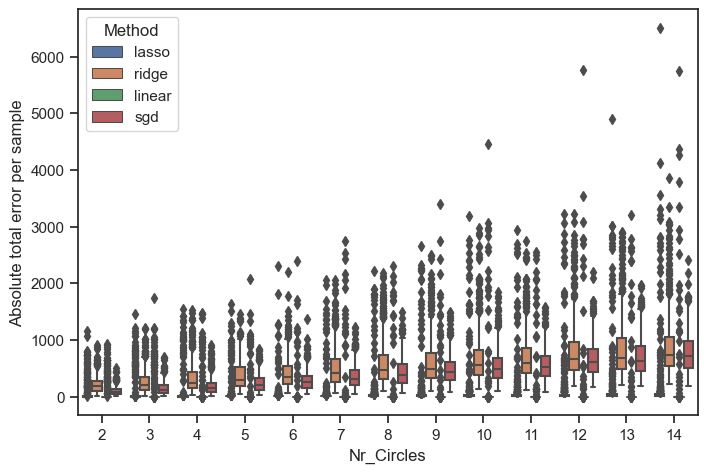

In [23]:
# All
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn
sns.set(rc={'figure.figsize':(8,5.27)})
sns.set(font="Arial")
sns.set_theme(style="ticks")

sns.set_style("whitegrid")
sns.set(font="Arial")
sns.set(font_scale=1)
sns.set_style("ticks")

g=sns.boxplot(x="Nr_Circles", y="Error", hue="Method", data=df_metrics)
g.set_ylabel("Absolute total error per sample")
plt.savefig("../data/lasso_experiments/figures/lasso_experiment_overlap.png",bbox_inches='tight')
plt.savefig("../data/lasso_experiments/figures/lasso_experiment_overlap.svg",bbox_inches='tight')
plt.savefig("../data/lasso_experiments/figures/lasso_experiment_overlap.pdf",bbox_inches='tight')

Split also by the Nr_Fragments.

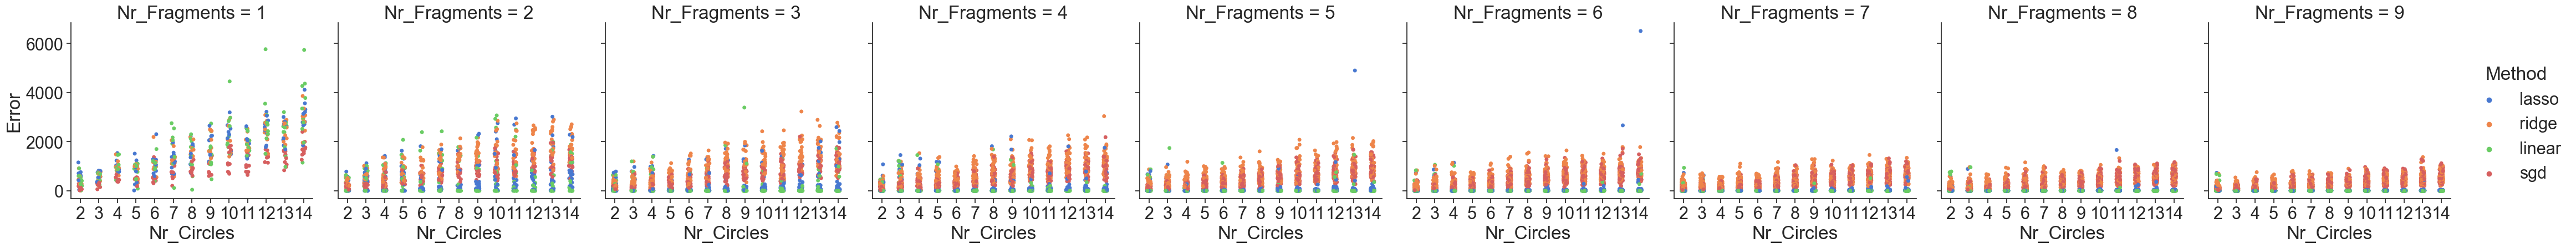

In [13]:
sns.set(font="Arial")
sns.set(font_scale=2)
sns.set_style("ticks")
sns.catplot(x="Nr_Circles", y="Error", hue="Method", data=df_metrics, palette="muted",col="Nr_Fragments")

We do observe that is easier to find correct proportions for circles with multiple fragments (also overlapping).<br/>
For non-overlapping circles it seems that the method does not work optimal.<br/>
Overall, Lasso performs best. For independent variables, SGD performs best (see Nr_Fragments = 1)

Example of incorrect fit (2 fragments x 2 circles)

In [14]:
sim_dict[1]["matrix"]

,0,1
99,0,1
31,1,0


In [15]:
"Absolute total error (lasso, ridge, simple, sgd)", sim_dict[1]["errors"]

('Absolute total error (lasso, ridge, simple, sgd)',
 (710.4642960956312, 567.3635091109259, 567.3635091109259, 263.6675582862482))

In [16]:
"True quantification ", sim_dict[1]["proportions"]

('True quantification ', [211.93136106311022, 355.4321480478156])

In [17]:
"Fit coeficients ", sim_dict[1]["coefs"]

('Fit coeficients ',
 (array([-1.43100787e+02,  1.14352972e-14]),
  array([-35.87519675,  35.87519675]),
  array([-71.75039349,  71.75039349]),
  array([106.78772338, 196.90822745])))

<br/>
Example of incorrrect fit (10 fragments x 10 circles)

In [18]:
sim_dict[3600]["matrix"]

,0,1,2,3,4,5,6,7,8,9
69,0,0,0,0,0,0,1,0,0,0
39,0,1,0,0,0,0,0,0,0,0
45,0,0,0,1,0,0,0,0,0,0
47,0,0,0,0,0,0,0,0,1,0
17,0,0,0,0,0,0,0,1,0,0
50,0,0,0,0,0,0,0,0,0,1
51,0,0,0,0,0,1,0,0,0,0
84,1,0,0,0,0,0,0,0,0,0
87,0,0,1,0,0,0,0,0,0,0
90,0,0,0,0,1,0,0,0,0,0


In [19]:
"Absolute total error (lasso, ridge, simple, sgd)", sim_dict[3600]["errors"]

('Absolute total error (lasso, ridge, simple, sgd)',
 (1618.7666531755995,
  1393.7896152147127,
  1879.1917514817824,
  693.1676524027275))

In [20]:
"True quantification ", sim_dict[3600]["proportions"]

('True quantification ',
 [192.445807189951,
  -69.22850205710898,
  17.85620999625857,
  223.31712245609577,
  351.7810268152606,
  21.127064036100194,
  -11.879039623173782,
  337.81735914521914,
  132.16137205390123,
  198.3911952022089])

In [21]:
"Fit coeficients ", sim_dict[3600]["coefs"]

('Fit coeficients ',
 (array([  29.56823839, -230.1049747 , -143.01916121,   60.44147466,
          188.90430303, -139.75010123, -172.75626432,  174.94035618,
          -28.71543864,   35.51452988]),
  array([  26.53342283, -104.30373179,  -60.76137576,   41.96908047,
          106.20103265,  -59.12594874,  -75.62900057,   99.21919881,
           -3.60879473,   29.50611684]),
  array([380.36498234, 118.69067309, 205.77538514, 411.2362976 ,
         539.70020196, 209.04623918, 176.04013553, 525.73653429,
         320.0805472 , 386.31037035]),
  array([118.18772351, -13.72014399,  30.87946358, 133.77052636,
         197.69968527,  32.47642038,  15.35164877, 191.00444425,
          88.00341607, 121.19209138])))

### 1.2 Simulate samples containing ecDNA + include subcircles in the linear regression matrix

Perform same simulation as above but include all the subcircles (these will be also the output from the graph).

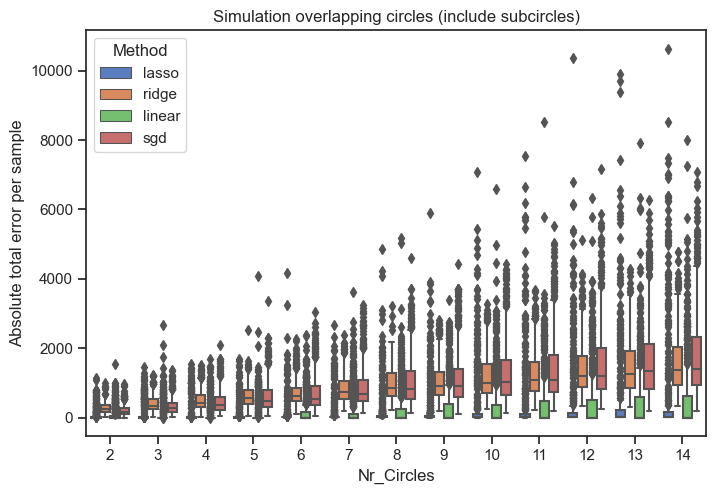

In [24]:
# All
import pandas as pd
import numpy as np

# seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(8,5.27)})
sns.set(font="Arial")
sns.set_theme(style="ticks")

g = sns.boxplot(x="Nr_Circles", y="Error", hue="Method", data=df_metrics1, palette="muted")
g.set_title("Simulation overlapping circles (include subcircles)")
g.set_ylabel("Absolute total error per sample")
plt.savefig("../data/lasso_experiments/figures/lasso_experiment_overlap_subcircles.png",bbox_inches='tight')
plt.savefig("../data/lasso_experiments/figures/lasso_experiment_overlap_subcircles.svg",bbox_inches='tight')
plt.savefig("../data/lasso_experiments/figures/lasso_experiment_overlap_subcircles.pdf",bbox_inches='tight')

In [ ]:
df_metrics.tail()

### 1.3 How much error is introduced by adding all the possible simple circles?

In [ ]:
df_merge = pd.merge(df_metrics, df_metrics1, on=["Method","Nr_Circles","Nr_Fragments","Nr_Overlapping_Frags","Sim"])
df_merge["Add_Error"] = abs(df_merge.Error_x - df_merge.Error_y)

In [ ]:
df_merge.tail()

Text(0, 0.5, 'Absolute total error per sample')

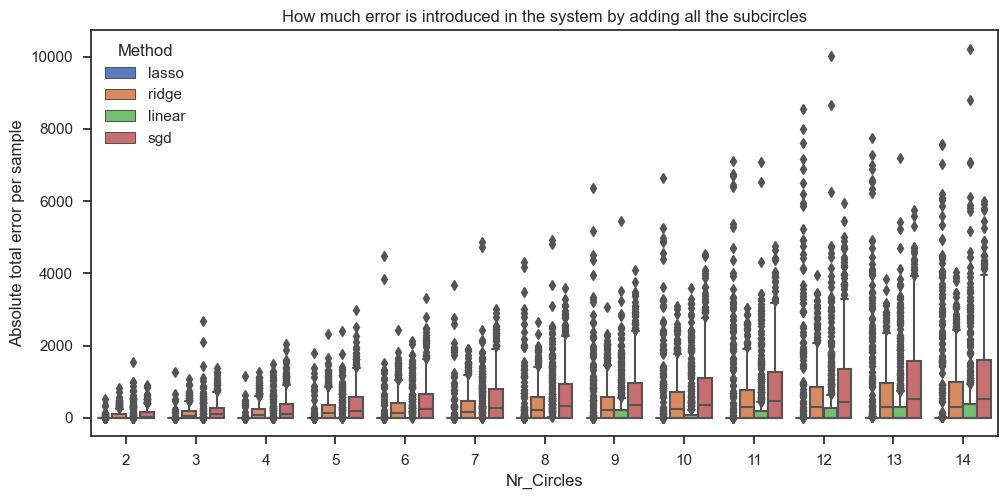

In [78]:
# All
import pandas as pd
import numpy as np

# matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# plotly
import plotly.io as pio
import plotly.express as px

# seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,5.27)})
sns.set(font="Arial")
sns.set(font_scale=5)
sns.set_theme(style="ticks")

g=sns.boxplot(x="Nr_Circles", y="Add_Error", hue="Method", data=df_merge, palette="muted")
g.set_title("How much error is introduced in the system by adding all the subcircles")
g.set_ylabel("Absolute total error per sample")

In [62]:
df_merge[(df_merge.Method == "lasso") & (df_merge.Add_Error > 100)]

,Error_x,Method,Nr_Circles,Nr_Fragments,Nr_Overlapping_Frags,Sim,Error_y,Add_Error
212,0.800138,lasso,2,3,2,53,139.684850,138.884712
320,0.901193,lasso,2,4,2,80,133.461680,132.560487
328,0.902807,lasso,2,4,2,82,312.764892,311.862085
336,0.901593,lasso,2,4,2,84,177.937363,177.035770
500,1.080140,lasso,2,5,2,125,106.648261,105.568121
...,...,...,...,...,...,...,...,...
23380,32.696597,lasso,14,9,8,5845,1483.722285,1451.025688
23384,24.725243,lasso,14,9,8,5846,4547.679887,4522.954644
23388,17.372015,lasso,14,9,8,5847,3858.854360,3841.482345
23392,88.617309,lasso,14,9,8,5848,4626.801634,4538.184325
